### [실험 B] 활성화 함수 비교 :  ReLU vs LeakyReLU vs Sigmoid (스케쥴링 x)


###  실험 목표
  - ReLU, LeakyReLU, Sigmoid가 학습에 미치는 영향을 분석
  - Dead ReLU 발생 유도 및 LeakyReLU의 완화 효과 확인

---
코드를 일괄적으로 돌리면 모든 활성화 함수에 대해 일괄적으로 결과 확인 가능


c:\Users\user\anaconda3\envs\dl_cuda126\lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.1)
  from scipy.sparse import csr_matrix, issparse



[Activation: ReLU]
최종 Test Accuracy: 0.8833


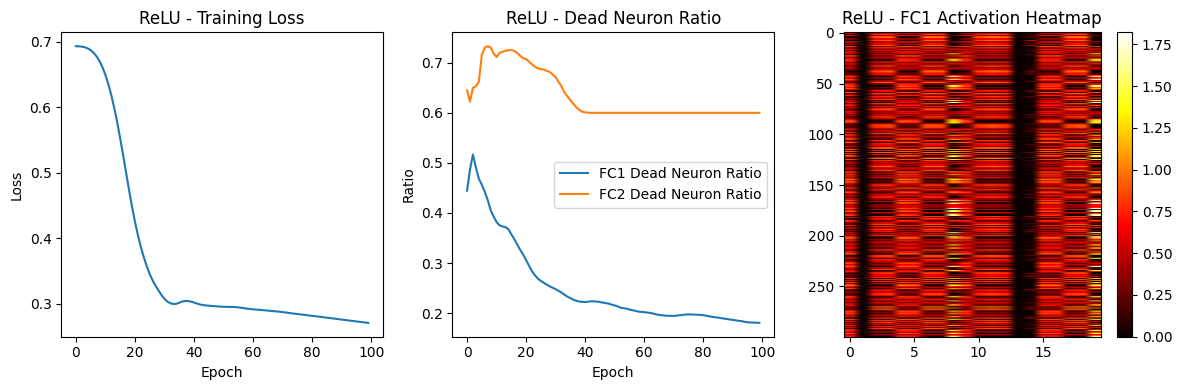


[Activation: LeakyReLU]
최종 Test Accuracy: 0.8900


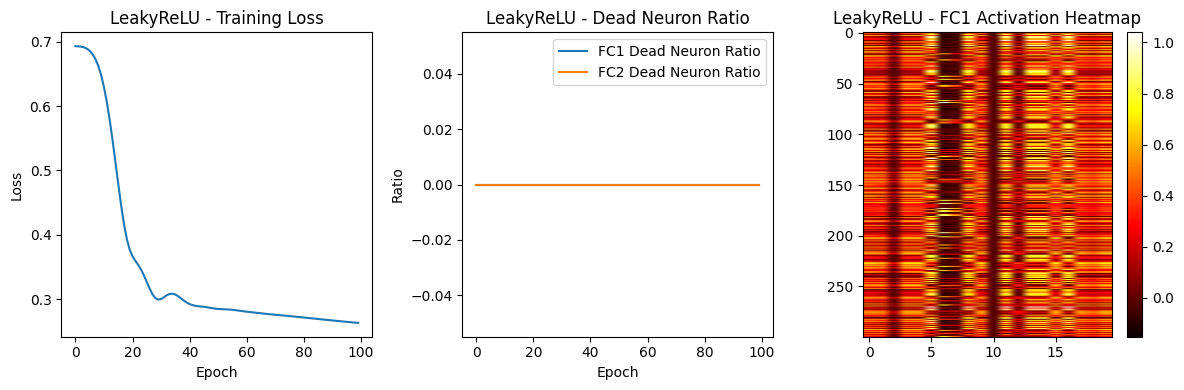


[Activation: Sigmoid]
최종 Test Accuracy: 0.8800


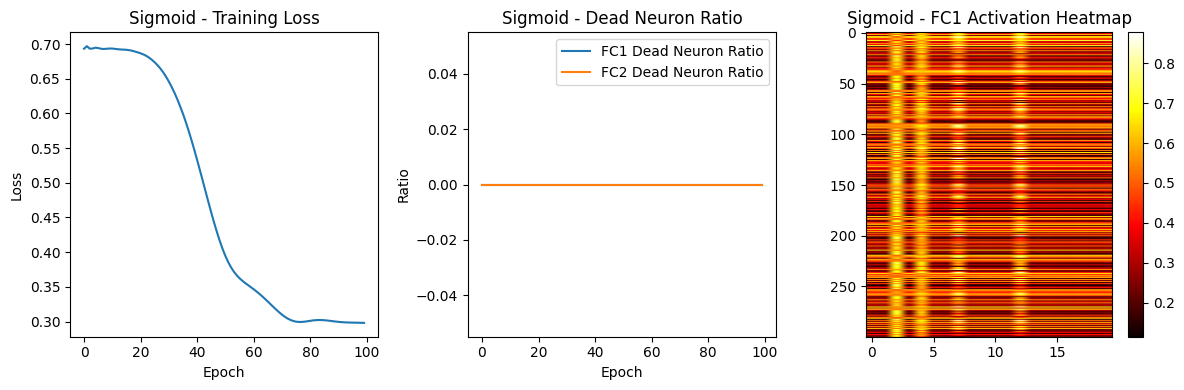

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#---------------------------------------------------------------------데이터 선언
# 비선형 분류 문제- makemoon 음양기호만들기
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

#---------------------------------------------------------------------학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

#---------------------------------------------------------------------데이터-> PyTorch 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

#---------------------------------------------------------------------학습 epoch 수
epochs = 100

#---------------------------------------------------------------------MLP 모델정의의
class SimpleNet(nn.Module):
    def __init__(self, activation):
        super().__init__()
        # 2차원 입력 -> 은닉층 1: 20차원 -> 은닉층 2: 20차원 -> 출력층: 2 클래스
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 2)
        self.activation = activation  # 활성화 함수는 실험마다 바뀜

        # 가중치 초기화: 평균 0, 표준편차 0.01의 정규분포
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # 순전파 및 중간 출력 저장 for죽은뉴런 분석석
        self.out1 = self.activation(self.fc1(x))  # FC1 후 활성화
        self.out2 = self.activation(self.fc2(self.out1))  # FC2 후 활성화
        out = self.fc3(self.out2)  # FC3 (출력층)에는 활성화 적용 안 함
        return out

#---------------------------------------------------------------------죽은 뉴런 비 계산산
def dead_neuron_ratio(activation_output):
    # ReLU 계열에서는 출력이 정확히 0인 뉴런을 dead로 간주
    dead = (activation_output == 0).float()
    ratio = dead.mean().item()  # 전체 뉴런 중 0인 비율
    return ratio

#---------------------------------------------------------------------학습 & 평가
def train_and_evaluate(activation, act_name):
    print(f"\n[Activation: {act_name}]")

    # 모델, 손실함수, 옵티마이저 정의
    model = SimpleNet(activation) #모델
    criterion = nn.CrossEntropyLoss() # 손실함수: 크로스엔트로피
    optimizer = optim.Adam(model.parameters(), lr=0.01) #옵티마이저 : adam

    # 시각화 기록용 리스트
    train_losses = []
    dead_ratios_fc1 = []
    dead_ratios_fc2 = []

    #############################학습루프##########################

    for epoch in range(epochs):
        model.train()                       # 학습모드
        optimizer.zero_grad()               # 이전 기울기 초기화

        # 순전파
        outputs = model(X_train)            # 예측값
        loss = criterion(outputs, y_train)  # 크로스엔트로피(실측,예측)값 적층층

        # 역전파 및 가중치 갱신
        loss.backward()                     # 손실값 기반으로 역전파진행 - 현재의 기울기
        optimizer.step()                    # 최적화기로 수렴

        train_losses.append(loss.item())    # 에포크의 손실값을 저장장

        #---------------------------------------------에포크 끝날때마다 죽은 뉴런 탐색
        model.eval() # 평가 모드로 변환
        with torch.no_grad():
            out1 = model.out1               # FC1 활성화함수값 출력
            out2 = model.out2               # FC2 활성화함수값 출력
            dead_ratios_fc1.append(dead_neuron_ratio(out1)) # 1층에서 죽은 뉴런 개수수
            dead_ratios_fc2.append(dead_neuron_ratio(out2)) # 2층에서 죽은 뉴런 개수수

    # -------------------------------------------------- 테스트 정확도 계산
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, preds = torch.max(test_outputs, 1)
        acc = (preds == y_test).float().mean().item()

    print(f"최종 Test Accuracy: {acc:.4f}")

    # --------------------------------------------------- 시각화
    plt.figure(figsize=(12, 4))

    # 1. 학습손실그래프 출력
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title(f'{act_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # 2. 죽은 뉴런 비율 그래프
    plt.subplot(1, 3, 2)
    plt.plot(dead_ratios_fc1, label='FC1 Dead Neuron Ratio')
    plt.plot(dead_ratios_fc2, label='FC2 Dead Neuron Ratio')
    plt.title(f'{act_name} - Dead Neuron Ratio')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio')
    plt.legend()

    # 3. n번째 에폭의 은닉층 1에서의 출력값 히트맵
    plt.subplot(1, 3, 3)
    plt.imshow(model.out1.detach().numpy(), aspect='auto', cmap='hot')
    plt.title(f'{act_name} - FC1 Activation Heatmap')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

 # ---------------------------------------------------실험수행
# 세 활성화 함수에 대해 실험
train_and_evaluate(nn.ReLU(), 'ReLU')
train_and_evaluate(nn.LeakyReLU(0.07), 'LeakyReLU')
train_and_evaluate(nn.Sigmoid(), 'Sigmoid')
